In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/ai_for_medicine

Mounted at /content/drive/
/content/drive/MyDrive/Projects/ai_for_medicine


In [ ]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox

In [ ]:
class CardiacDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_labels_csv, patients, root_path, augs = False):
    self.labels = pd.read_csv(path_to_labels_csv)
    self.patients = np.load(patients)
    self.root_path = Path(root_path)
    self.augment = augs

  def __len__(self):
    return len(self.patients)

  def __getitem__(self, idx):
    patient = self.patients[idx]
    data = self.labels[self.labels['name'] == patient]

    x_min = data["x0"].item()
    y_min = data["y0"].item()
    x_max = x_min + data["w"].item()
    y_max = y_min + data["h"].item()
    bbox = [x_min, y_min, x_max, y_max]

    file_path = self.root_path / patient
    img = np.load(f"{file_path}.npy").astype(np.float32)

    if self.augment:
      bb = BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max)
      random_seed = torch.randint(0, 10000, (1,)).item()
      imgaug.seed(random_seed)

      img, aug_bbox = self.augment(image=img, bounding_boxes=bb)

      bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]

    img = (img - 0.494) / 0.252
    img = torch.tensor(img).unsqueeze(0)
    bbox = torch.tensor(bbox)

    return img, bbox


In [ ]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
train_transform = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale = (0.8, 1.2),
        rotate = (-10, 10),
        translate_px = (-10, 10)
    )
])

In [ ]:
labels_path = "Data/heart_detection/rsna_heart_detection.csv"

train_subjects_path = "Data/heart_detection/processed/train_subjects.npy"
train_root_path = "Data/heart_detection/processed/train"
val_subjects_path = "Data/heart_detection/processed/val_subjects.npy"
val_root_path = "Data/heart_detection/processed/val"

In [ ]:
train_data = CardiacDataset(labels_path, train_subjects_path, train_root_path, train_transform)
val_data = CardiacDataset(labels_path, val_subjects_path, val_root_path)

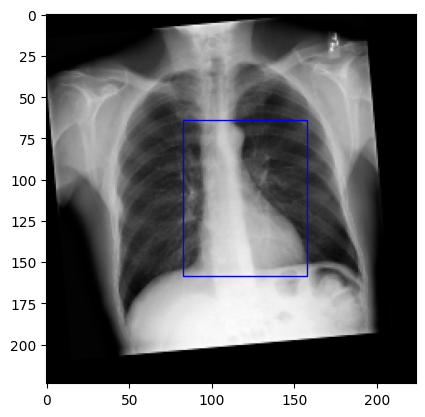

In [ ]:
img, bbox = train_data[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img.squeeze(), cmap="gray")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='b', facecolor='none')
axis.add_patch(rect)
plt.show()

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

In [ ]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
class CardiacDetectionModel(torch.nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

        # Extracting the layer of interest for visualization
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, x):
        # Passing through the feature extractor
        features = self.feature_extractor(x)
        # Continue through the rest of the model
        x = self.model(x)
        return x, features


In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
model = CardiacDetectionModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)

In [ ]:
for epoch in range(189):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs, feature = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs.squeeze(), labels.float())  # Adjust the output shape if necessary
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    scheduler.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, feature = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs.squeeze(), labels.float())

            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')


Epoch 1, Train Loss: 16779.3402, Val Loss: 15634.6489
Epoch 2, Train Loss: 16028.1500, Val Loss: 14965.3188
Epoch 3, Train Loss: 15216.1229, Val Loss: 14370.7357
Epoch 4, Train Loss: 14710.1726, Val Loss: 13731.9201
Epoch 5, Train Loss: 13982.4127, Val Loss: 12909.4769
Epoch 6, Train Loss: 13097.8283, Val Loss: 12141.2619
Epoch 7, Train Loss: 12301.5612, Val Loss: 11405.6267
Epoch 8, Train Loss: 11505.2437, Val Loss: 10619.8677
Epoch 9, Train Loss: 10813.9973, Val Loss: 9971.6969
Epoch 10, Train Loss: 10032.6567, Val Loss: 9090.5443
Epoch 11, Train Loss: 9469.4395, Val Loss: 8268.2111
Epoch 12, Train Loss: 8665.4197, Val Loss: 8073.2067
Epoch 13, Train Loss: 7980.8236, Val Loss: 7130.8684
Epoch 14, Train Loss: 7484.8311, Val Loss: 6592.1936
Epoch 15, Train Loss: 6975.3547, Val Loss: 6262.0706
Epoch 16, Train Loss: 6372.6064, Val Loss: 5731.4058
Epoch 17, Train Loss: 5850.8776, Val Loss: 5098.0128
Epoch 18, Train Loss: 5521.5985, Val Loss: 4623.1224
Epoch 19, Train Loss: 4960.3655, Val 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Epoch 97, Train Loss: 43.5521, Val Loss: 58.4419
Epoch 98, Train Loss: 43.1140, Val Loss: 39.5329


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 99, Train Loss: 48.4677, Val Loss: 46.8693


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
AssertionError    : if w.is_alive():can only test a child process

  File "/usr/lib/

Epoch 100, Train Loss: 45.3248, Val Loss: 45.5534


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 101, Train Loss: 41.3714, Val Loss: 44.1566


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 102, Train Loss: 39.9972, Val Loss: 51.4874


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 103, Train Loss: 43.4523, Val Loss: 40.1139


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 104, Train Loss: 35.1738, Val Loss: 44.6780


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

AssertionError    : can only test a child processif w.is_alive():

  File "/usr/lib/

Epoch 105, Train Loss: 35.6197, Val Loss: 53.1241


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch 106, Train Loss: 38.7637, Val Loss: 43.7246


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0><function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only te

Epoch 107, Train Loss: 36.4826, Val Loss: 47.8864


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 108, Train Loss: 40.2490, Val Loss: 47.1566


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 109, Train Loss: 35.9356, Val Loss: 40.7139


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x799a887893f0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
:     can only test a child processif w.is_alive():

  File "/usr/lib/

Epoch 110, Train Loss: 38.3952, Val Loss: 48.0784
Epoch 111, Train Loss: 34.3276, Val Loss: 45.0723
Epoch 112, Train Loss: 41.7771, Val Loss: 58.5562
Epoch 113, Train Loss: 38.2227, Val Loss: 39.2293
Epoch 114, Train Loss: 38.3725, Val Loss: 48.1938
Epoch 115, Train Loss: 32.1137, Val Loss: 40.4832
Epoch 116, Train Loss: 37.2137, Val Loss: 48.5910
Epoch 117, Train Loss: 32.3127, Val Loss: 42.2411
Epoch 118, Train Loss: 33.6428, Val Loss: 42.8797
Epoch 119, Train Loss: 34.5561, Val Loss: 45.8864
Epoch 120, Train Loss: 29.2468, Val Loss: 41.8220
Epoch 121, Train Loss: 32.7917, Val Loss: 41.2054
Epoch 122, Train Loss: 31.4078, Val Loss: 37.9554
Epoch 123, Train Loss: 33.0863, Val Loss: 39.3693
Epoch 124, Train Loss: 32.6141, Val Loss: 52.5437
Epoch 125, Train Loss: 36.1056, Val Loss: 41.3409
Epoch 126, Train Loss: 33.5317, Val Loss: 43.2352
Epoch 127, Train Loss: 31.7749, Val Loss: 42.1883
Epoch 128, Train Loss: 36.9613, Val Loss: 45.0685
Epoch 129, Train Loss: 26.5541, Val Loss: 42.5172


In [ ]:
model_save_path = 'models/cardiac_detection_RESNET18.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
model.load_state_dict(torch.load('models/cardiac_detection_RESNET18.pth'))

<All keys matched successfully>

In [ ]:
preds = []
labels = []

with torch.no_grad():
  for data, label in val_data:
      data = data.to(device).float().unsqueeze(0)
      pred, features = model(data)
      pred = pred[0].cpu()

      preds.append(pred)
      labels.append(label)

preds = torch.stack(preds)
labels = torch.stack(labels)

In [ ]:
abs(preds-labels).mean(0)

tensor([4.8040, 4.0089, 3.9625, 5.3921])

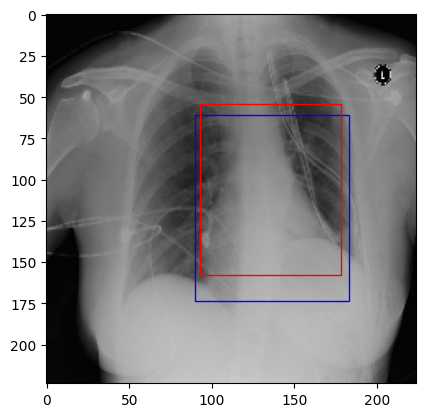

In [ ]:
IDX = 10
img, label = val_data[IDX]
pred = preds[IDX]
label = labels[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap='gray')

heart_pred = patches.Rectangle((pred[0], pred[1]), pred[2] - pred[0], pred[3] - pred[1], linewidth=1, edgecolor='b', facecolor='none')
heart_gt = patches.Rectangle((label[0], label[1]), label[2] - label[0], label[3] - label[1], linewidth=1, edgecolor='r', facecolor='none')

axis.add_patch(heart_pred)
axis.add_patch(heart_gt)

In [ ]:
class CardiacDetectionModel(torch.nn.Module):
    def __init__(self):
        super(CardiacDetectionModel, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

        # Extracting the layer of interest for visualization
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, x):
        # Passing through the feature extractor
        features = self.feature_extractor(x)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input = features, output_size=(1, 1))
        avg_output_flattened = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flattened)
        # Continue through the rest of the model
        return pred, features


In [ ]:
model = CardiacDetectionModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.load_state_dict(torch.load('models/cardiac_detection_RESNET18.pth'), strict=False)
model.eval()

CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape((512, 49))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()


    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, pred

In [ ]:
def visualize(img, heatmap, pred):
    """
    Visualization function for class activation maps
    """
    img = img[0]
    # Resize the activation map of size 7x7 to the original image size (224x224)
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]

    # Create a figure
    fig, axis = plt.subplots(1, 2)

    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    # plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [ ]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

In [ ]:
img = train_data[23][0]  # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

In [ ]:
activation_map, pred

(tensor([[44.2745, 44.8962, 47.0308, 51.8654, 59.0584, 63.2816, 53.1498],
         [29.8506, 30.7938, 31.3423, 33.1510, 36.5022, 38.4303, 39.7697],
         [59.9122, 72.0728, 79.0698, 82.8601, 69.8560, 28.7900, 24.8862],
         [56.1709, 70.5043, 85.4427, 85.3405, 60.2519, 20.9473, 18.1895],
         [59.4086, 72.8549, 72.9819, 69.7449, 52.6290, 18.8662, 17.2265],
         [56.7795, 64.1778, 59.4735, 58.4658, 55.2581, 20.4387, 21.0600],
         [59.0698, 64.8274, 67.3484, 63.1149, 58.1596, 30.8632, 31.5583]]),
 tensor([ 50.9101,  67.6780, 142.7795, 171.3447]))

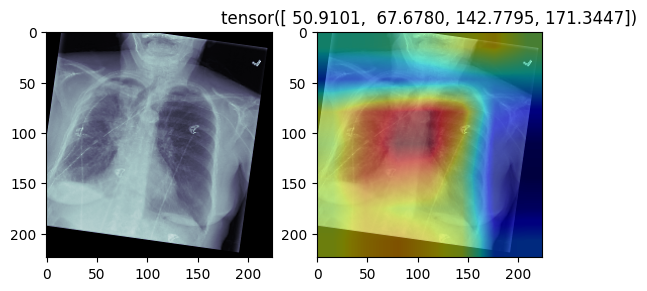

In [ ]:
visualize(img, activation_map, pred)  # Visualize CAM